# Business Understanding

## Loading Libraries and Data

Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

import collections

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data loading

All the data loaded in this cell was sourced from here: http://insideairbnb.com/get-the-data.html

In [2]:
#Porto related data
porto_listings = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\listings.csv")
porto_calendar = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\calendar.csv.gz", compression = 'gzip')
porto_neighbourhoods = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\neighbourhoods.csv")
porto_reviews = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\reviews.csv")

#Lisbon related data
lisbon_listings = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\listings.csv")
lisbon_calendar = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\calendar.csv.gz", compression = 'gzip')
lisbon_neighbourhoods = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\neighbourhoods.csv")
lisbon_reviews = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\reviews.csv")

### Cleanup and EDA

Since I will be comparing Porto to Lisbon one of the first things to check is if they have exactly the same columns on their dataframes.

In [3]:
def column_checker(porto_df, lisbon_df):
    '''
    Takes in 2 dataframes and checks if attributes match between the 2 dataframes 
    Args: any 2 dataframes 
    prints True or False if the dataframes match or not and which values are different
    '''
    porto_column_list = porto_df.columns.values
    lisbon_column_list = lisbon_df.columns.values
    
    equal = collections.Counter(porto_column_list) == collections.Counter(lisbon_column_list)
    
    print('The two tested dataframes are balanced: ', equal)
    
    if equal == False:
        print('The Porto df differs from Lisbon on the following columns: ')
        print(set(porto_column_list) - set(lisbon_column_list))
        
        print('The Lisbon df differs from the Porto df on the following colums: ')
        print(set(lisbon_column_list) - set(porto_column_list))

In [4]:
#checking column balance between listings
column_checker(porto_listings, lisbon_listings)

The two tested dataframes are balanced:  True


In [5]:
#checking column balance between calendar
column_checker(porto_calendar, lisbon_calendar)

The two tested dataframes are balanced:  True


In [6]:
#checking column balance between neighbourhoods
column_checker(porto_neighbourhoods, lisbon_neighbourhoods)

The two tested dataframes are balanced:  True


In [7]:
#checking column balance between reviews
column_checker(porto_reviews, lisbon_reviews)

The two tested dataframes are balanced:  True


In [8]:
#chekcing the shape of the dfs:
print(porto_listings.shape)
print(lisbon_listings.shape)
print(porto_calendar.shape)
print(lisbon_calendar.shape)
print(porto_reviews.shape)
print(lisbon_reviews.shape)
print(porto_neighbourhoods.shape)
print(lisbon_neighbourhoods.shape)

(11656, 16)
(25056, 16)
(4254440, 7)
(9145440, 7)
(501193, 2)
(1033354, 2)
(173, 2)
(134, 2)


The neighbourhoods dfs have information that is repeated in the listings df. So I will drop their usage from here on.

All the dataframes have the same columns which is great, no information needs to be dropped

Checking column data types

In [9]:
porto_listings.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [10]:
porto_calendar.dtypes

listing_id         int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [11]:
porto_neighbourhoods.dtypes

neighbourhood_group    object
neighbourhood          object
dtype: object

In [12]:
porto_reviews.dtypes

listing_id     int64
date          object
dtype: object

There are some columns with date and time data that need to be converted to floats and datetime formats, but it also seems like there is no difference between price and adjusted price in the calendar dataframe

In [13]:
#checking if there is a difference between price and adjusted_price
porto_calendar['price'].equals(porto_calendar['adjusted_price'])

False

In [14]:
lisbon_calendar['price'].equals(lisbon_calendar['adjusted_price'])

False

There seems to be a difference between them so I will keep both

In [15]:
def dtype_fixer(df, df_type):
    '''
    Takes in a dataframe and changes the datatypes of the specified columns 
    Args: a dataframe and the type of data it corresponds to
    Returns: dataframe with intended datatypes on the specified columns
    '''
    
    if df_type == 'calendar':
        
        #getting rid of the dollar sign 
        df['price'] = df['price'].str.replace('$', '')
        df['adjusted_price'] = df['adjusted_price'].str.replace('$', '')

        #cast object to float
        df['price'] = pd.to_numeric(df['price'],errors='coerce')
        df['adjusted_price'] = pd.to_numeric(df['adjusted_price'],errors='coerce')
    
        #convert datetime to date
        df['date'] = pd.to_datetime(df['date'])
        
    if df_type == 'listings':
        df['last_review'] = pd.to_datetime(df['last_review'])
    
    return df

In [16]:
dtype_fixer(porto_calendar, 'calendar')
dtype_fixer(lisbon_calendar, 'calendar')
dtype_fixer(porto_listings, 'listings')
dtype_fixer(lisbon_listings, 'listings')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6499,Belém 1 Bedroom Historical Apartment,14455,Bruno,Lisboa,Belm,38.69675,-9.19840,Entire home/apt,36,3,25,2019-11-05,0.39,1,0
1,25659,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",107347,Ellie,Lisboa,Santa Maria Maior,38.71167,-9.12696,Entire home/apt,60,3,112,2019-11-08,1.64,1,331
2,28066,ear the birds,120855,Lucia,Azambuja,Aveiras de Cima,39.14654,-8.91503,Private room,53,1,0,NaT,NaN,1,365
3,29138,Room for rent in shared house,125304,Susana,Lisboa,Areeiro,38.73634,-9.13792,Private room,71,1,0,NaT,NaN,1,365
4,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.71272,-9.12628,Entire home/apt,60,3,319,2019-10-29,2.94,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25051,40420286,Up Up & a Bay,4972896,Rita Morais,Cascais,Cascais e Estoril,38.70160,-9.38394,Entire home/apt,75,1,0,NaT,NaN,38,353
25052,40420363,From Estoril topfloor watching the Bay,4972896,Rita Morais,Cascais,Cascais e Estoril,38.70160,-9.38394,Entire home/apt,79,1,0,NaT,NaN,38,353
25053,40420871,"Spinel Bronze Apartment, Marques de Pombal, Li...",1969293,Tiago,Lisboa,Arroios,38.72640,-9.14130,Entire home/apt,165,2,0,NaT,NaN,55,346
25054,40422791,Graça Cosy Apartment with terrace,175257972,Ana Rita,Lisboa,So Vicente,38.71806,-9.12514,Entire home/apt,60,2,0,NaT,NaN,7,165


Visualizing missing values

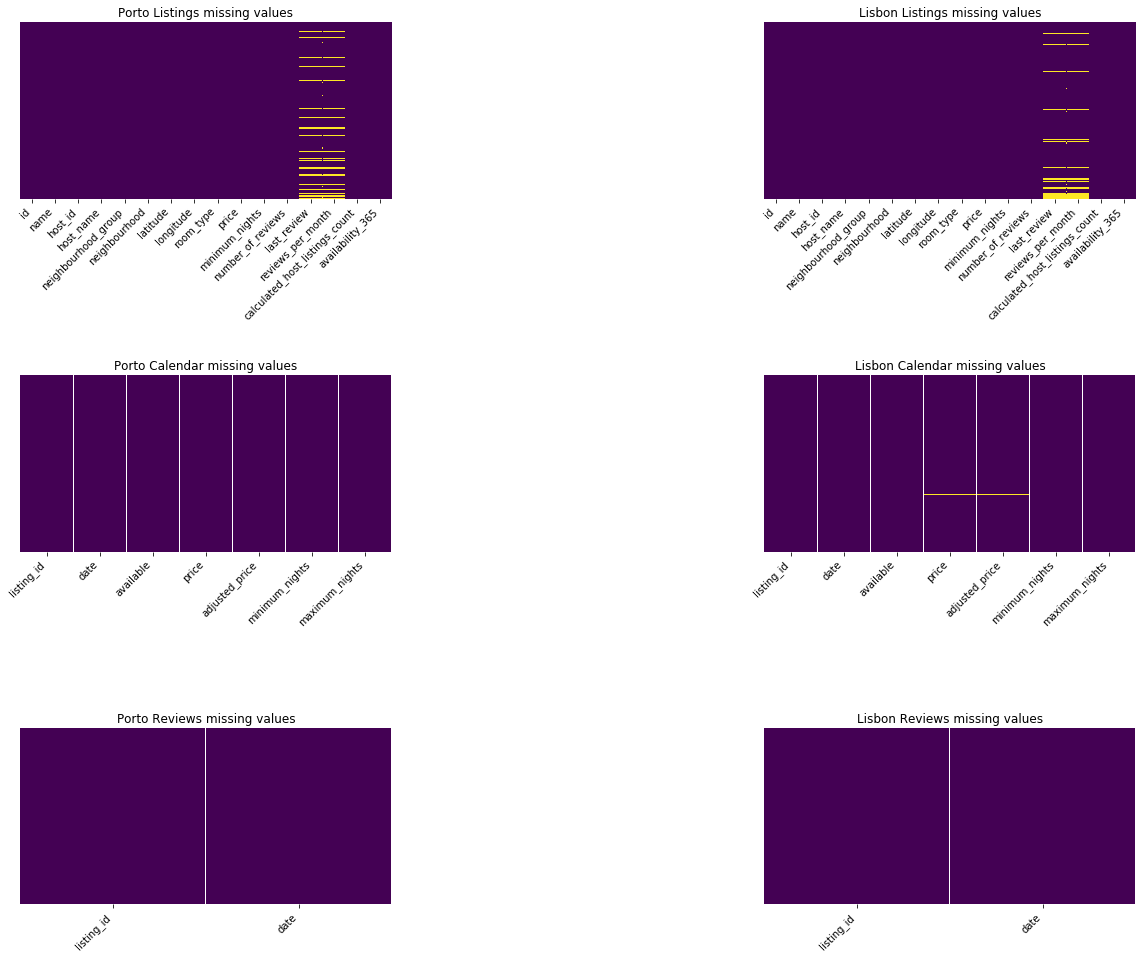

In [17]:
#pyplot is matplotlibs graphing framework, let's use it to make some subplots
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)


sns.heatmap(porto_listings.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax1)
ax1.set_title('Porto Listings missing values')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_listings.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax2)
ax2.set_title('Lisbon Listings missing values')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(porto_calendar.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax3)
ax3.set_title('Porto Calendar missing values')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_calendar.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax4)
ax4.set_title('Lisbon Calendar missing values')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(porto_reviews.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax5)
ax5.set_title('Porto Reviews missing values')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_reviews.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax6)
ax6.set_title('Lisbon Reviews missing values')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation = 45, horizontalalignment='right')


fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

In [18]:
#checking for missing values
def missing_checker(df, df_type):
    '''
    Takes in a dataframe and determines th number of missing values  
    Args: a dataframe 
    Prints: number of missing values
    '''
    #print('Number of missing values in ' + title + ' is: ')
    #print(df.isnull().sum())
    
    #percentage of missing values
    percent_missing = df.isnull().sum()* 100/len(df)
    #percent_missing_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    print('_______________________' + df_type + '_______________________')
    print(percent_missing)

In [19]:
missing_checker(porto_listings, 'porto_listings')

_______________________porto_listings_______________________
id                                 0.000000
name                               0.017159
host_id                            0.000000
host_name                          0.300275
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       13.375086
reviews_per_month                 13.375086
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64


In [20]:
missing_checker(lisbon_listings, 'lisbon_listings')

_______________________lisbon_listings_______________________
id                                 0.000000
name                               0.087803
host_id                            0.000000
host_name                          0.103768
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       14.635217
reviews_per_month                 14.635217
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64


In [21]:
missing_checker(porto_calendar, 'porto_calendar')

_______________________porto_calendar_______________________
listing_id        0.000000
date              0.000000
available         0.000000
price             0.320136
adjusted_price    0.318585
minimum_nights    0.000000
maximum_nights    0.000000
dtype: float64


In [22]:
missing_checker(lisbon_calendar, 'lisbon_calendar')

_______________________lisbon_calendar_______________________
listing_id        0.000000
date              0.000000
available         0.000000
price             0.532834
adjusted_price    0.531478
minimum_nights    0.000000
maximum_nights    0.000000
dtype: float64


In [23]:
missing_checker(porto_reviews, 'porto_reviews')

_______________________porto_reviews_______________________
listing_id    0.0
date          0.0
dtype: float64


In [24]:
missing_checker(lisbon_reviews, 'lisbon_reviews')

_______________________lisbon_reviews_______________________
listing_id    0.0
date          0.0
dtype: float64


In general it seems like there is very little data missing.
I am not a fan of getting rid of data as it dilutes the diversity of information we have in the dataset.
I will try to do some imputation on the missing values and create an extra column as an indicator of the places that required imputation.

In [25]:
#to help with the next steps I will extract a list of all the columns that have missing values and need to be dealt with
print('_______________________porto_listings missing list_______________________')
print(porto_listings.columns[porto_listings.isna().any()].tolist())

print('_______________________lisbon_listings missing list_______________________')
print(lisbon_listings.columns[lisbon_listings.isna().any()].tolist())

print('_______________________porto_calendar missing list_______________________')
print(porto_calendar.columns[porto_calendar.isna().any()].tolist())

print('_______________________lisbon_calendar missing list_______________________')
print(lisbon_calendar.columns[lisbon_calendar.isna().any()].tolist())

_______________________porto_listings missing list_______________________
['name', 'host_name', 'last_review', 'reviews_per_month']
_______________________lisbon_listings missing list_______________________
['name', 'host_name', 'last_review', 'reviews_per_month']
_______________________porto_calendar missing list_______________________
['price', 'adjusted_price']
_______________________lisbon_calendar missing list_______________________
['price', 'adjusted_price']


In [26]:
def missing_values_handler(df, df_type):
    '''
    Takes in a dataframe and creates a column to keep track of missing values
    Also does imputation on some of the missing values
    Args: a dataframe and the name of the dataframe
    Returns: df without missing values
    '''
    
    if df_type == 'listings':
        #creating a column to keep track of rows with missing values using booleans, missing values will be 0
        df['host_name_present'] = (~df['host_name'].isnull()).astype(int)
        
        #the name of the listing itself will not be relevant for the current analysis so I will drop it
        #so is the host_name
        df.drop(columns = ['name'], inplace = True)
        df.drop(columns = ['host_name'], inplace = True)
        
        #fill NaT with a mock date
        df['last_review_present'] = (~df['last_review'].isnull()).astype(int)
        date_replace = pd.to_datetime('2019-12-31')
        df['last_review'] = df['last_review'].replace({pd.NaT : date_replace})
        
        #fill the NaNs in the reviews per month after creating column to keep track of changes
        df['reviews_p_month_present'] = (~df['reviews_per_month'].isnull()).astype(int)
        df['reviews_per_month'] = df['reviews_per_month'].replace({np.nan : 0})
        
    if df_type == 'calendar':
        #the shape of the df demonstrates that it is a 7 figure number of rows show I will just drop
        # the under 200 data points missing
        df.dropna()
        
  
    return df

In [27]:
porto_listings_m = missing_values_handler(porto_listings, 'listings')
lisbon_listings_m = missing_values_handler(lisbon_listings, 'listings')
porto_calendar_m = missing_values_handler(porto_calendar, 'calendar')
lisbon_calendar_m = missing_values_handler(lisbon_calendar, 'calendar')

## Is there seasonality to the listings prices? 

In [28]:
porto_calendar_m.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,41339,2019-11-28,f,55.0,55.0,2,90
1,147502,2019-11-28,t,42.0,42.0,1,730
2,147502,2019-11-29,t,42.0,42.0,1,730
3,147502,2019-11-30,t,42.0,42.0,1,730
4,147502,2019-12-01,t,42.0,42.0,1,730


In [29]:
#determining the mean values of the listings
mean_price_porto = porto_calendar_m.groupby('date').mean()
mean_price_lisbon = lisbon_calendar_m.groupby('date').mean()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Average Listing Price')

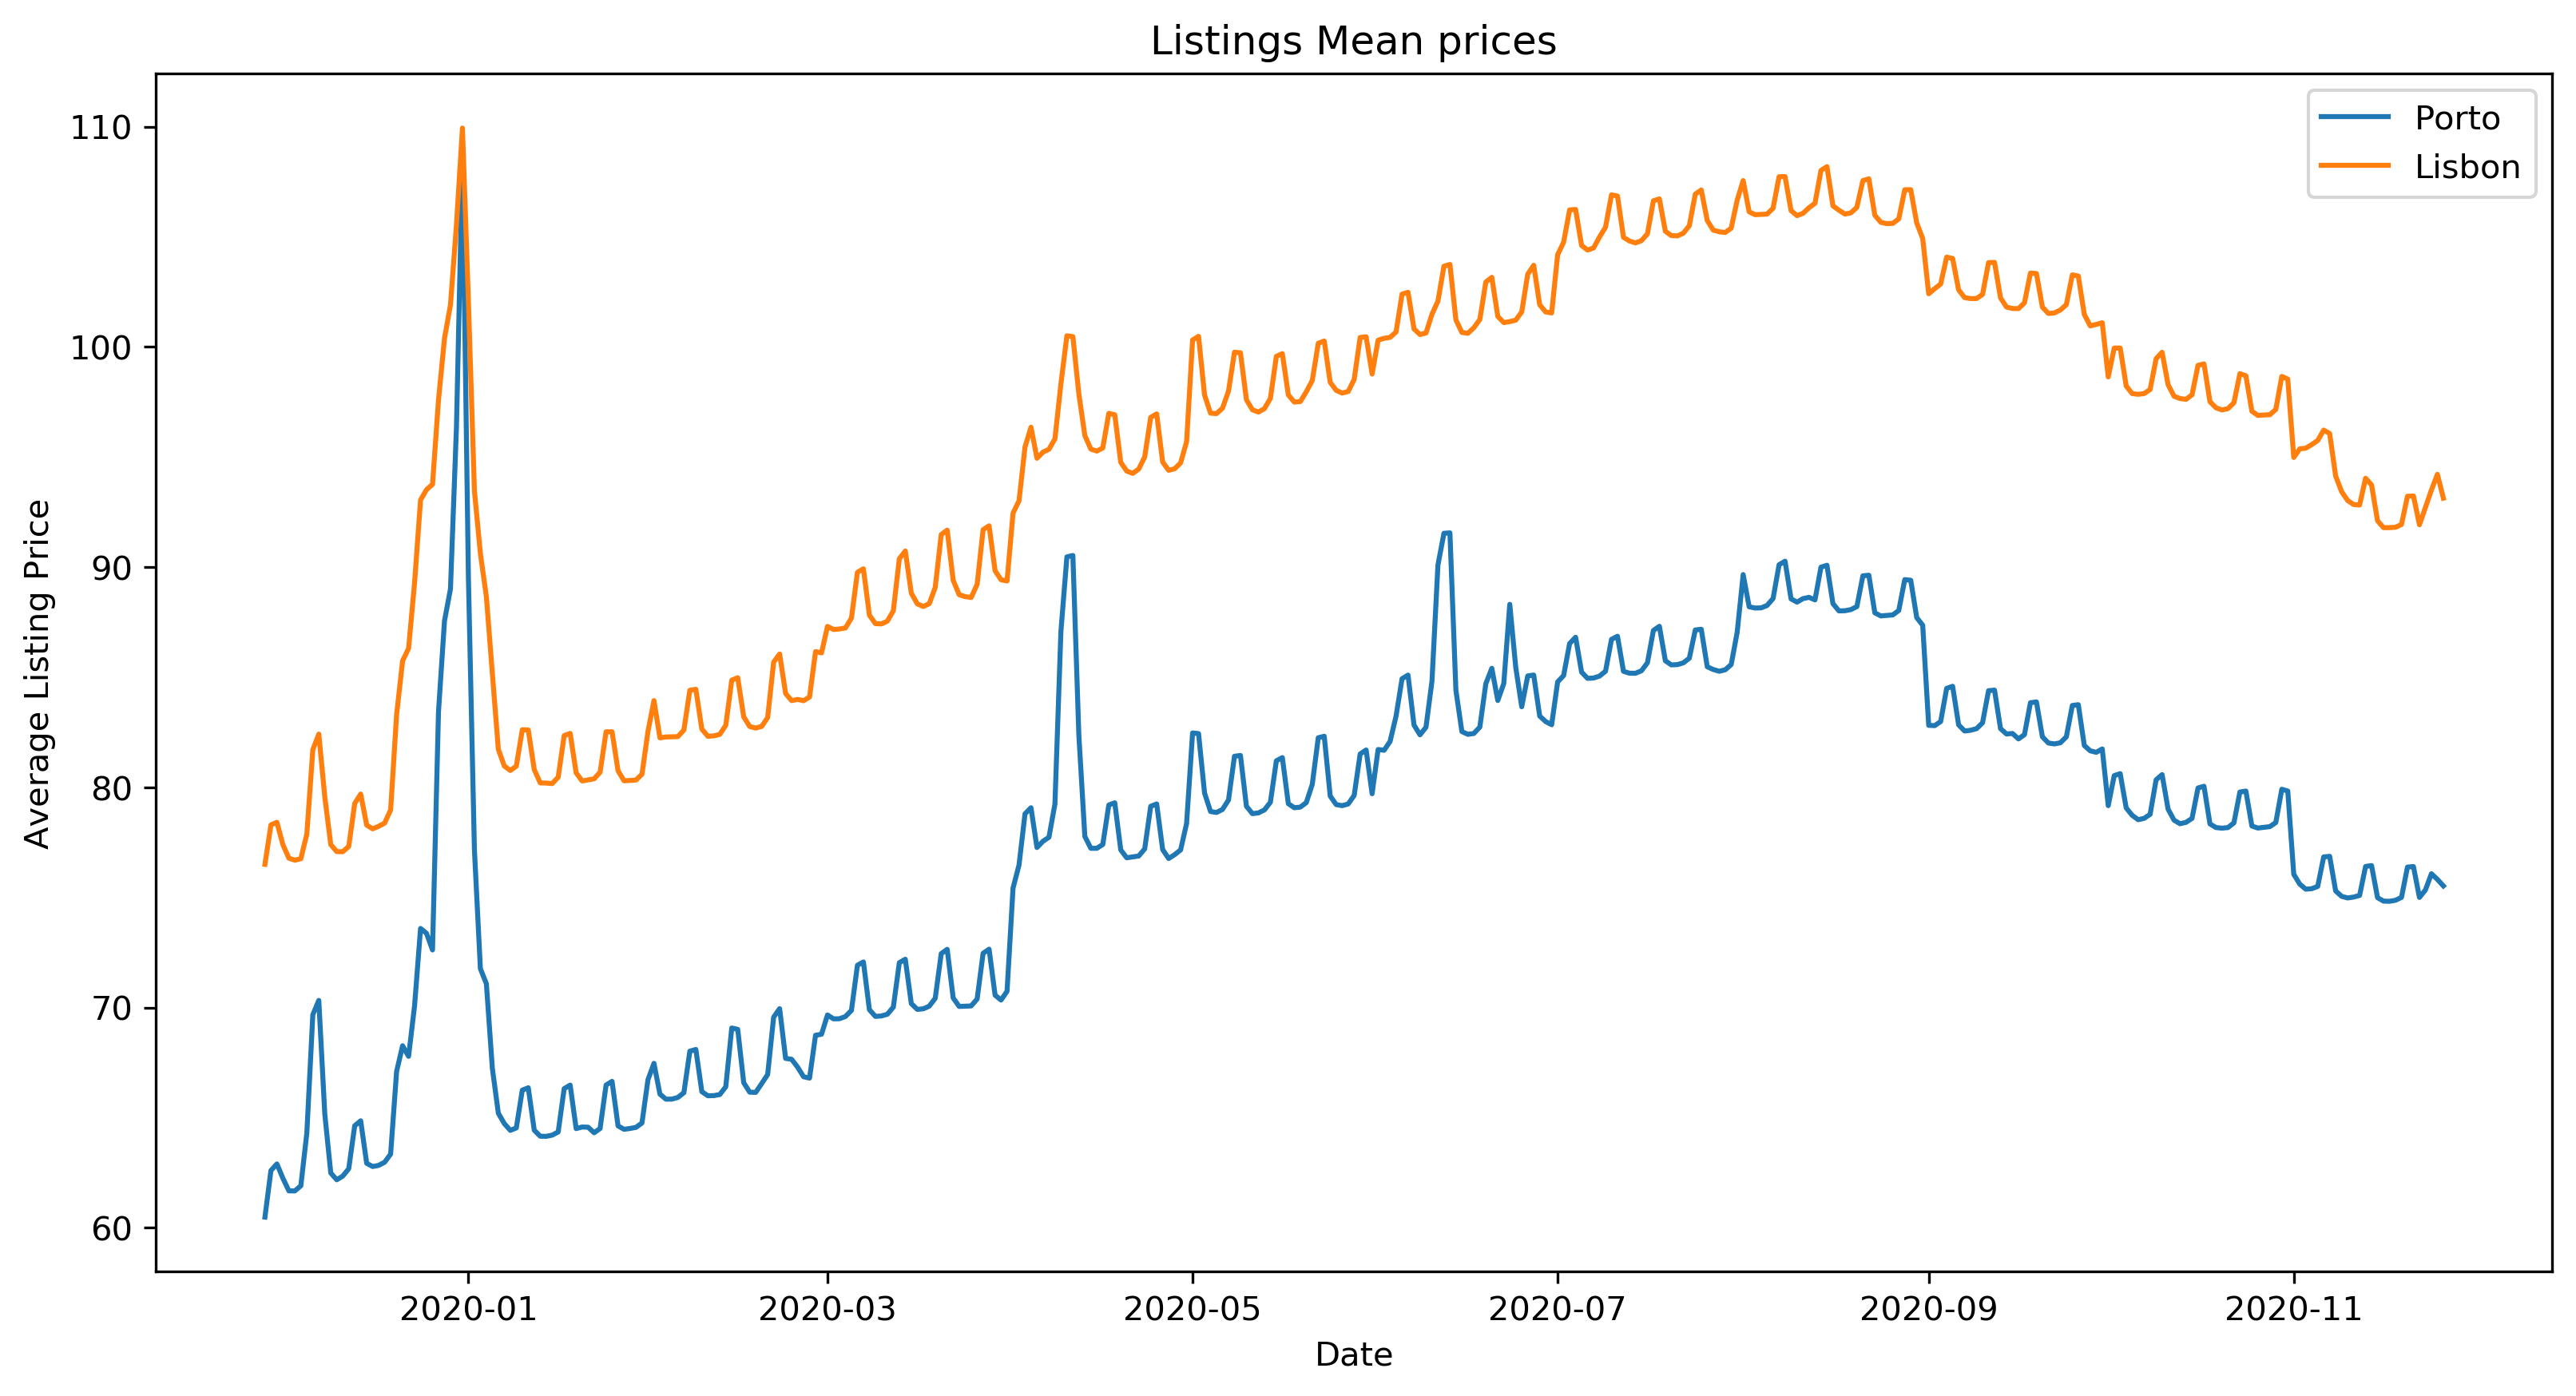

In [30]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])

ax.plot(mean_price_porto['price'], label = 'Porto')
ax.plot(mean_price_lisbon['price'], label = 'Lisbon')

ax.set_title('Listings Mean prices')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Listing Price')

There are very clear variations on the prices:
* first peak corresponds to NYE
* second peak probably corresponds to the 25th of April in Portugal
* third peak in porto probably corresponds to Saint John's celebrations/NOS Music festival/F1 Grand Prix

Before the next few steps I want to do some feature engineering to improve the status of some of categorical attributes

### Feature Engineering

In [31]:
porto_listings_m.neighbourhood_group.unique()

array(['PORTO', 'VILA NOVA DE GAIA', 'PAREDES', 'ESPINHO', 'MATOSINHOS',
       'SANTA MARIA DA FEIRA', 'GONDOMAR', 'VILA DO CONDE', 'AROUCA',
       'MAIA', 'VALONGO', 'PÓVOA DE VARZIM', 'OLIVEIRA DE AZEMÉIS',
       'VALE DE CAMBRA', 'TROFA', 'SANTO TIRSO', 'SÃO JOÃO DA MADEIRA'],
      dtype=object)

In [32]:
porto_listings_m.room_type.unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [33]:
def enc_and_eng(df, df_type):
    '''
    Takes in a dataframe and the string corresponding to the df_type and does feature encoding
    Args: a dataframe and the name of the dataframe
    Returns: df with encoded features
    '''
    if df_type == 'listings':
        #creating a list of the categorical features I want to get dummies for
        cat_features = ['neighbourhood_group', 'neighbourhood']
        #getting dummies
        df = pd.get_dummies(df, columns = cat_features, prefix = cat_features, drop_first = True)
        
        #creating a dictionary for the replacements in room types
        room_types = {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}
        df['room_type'] = df['room_type'].map(room_types)
        
    if df_type == 'calendar':
        #replacing the t and f in the available column with booleans
        available_type = {'f' : 0, 't' : 1}
        df['available'] = df['available'].map(available_type)
        
    return df

In [34]:
porto_listings_c = enc_and_eng(porto_listings_m, 'listings')
lisbon_listings_c = enc_and_eng(lisbon_listings_m, 'listings')
porto_calendar_c = enc_and_eng(porto_calendar_m, 'calendar')
lisbon_calendar_c = enc_and_eng(lisbon_calendar_m, 'calendar')

In [35]:
porto_listings_c.head()

,id,host_id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,neighbourhood_Vila Nova da Telha,neighbourhood_Vila de Cucujães,neighbourhood_Vila do Conde,neighbourhood_Vilar de Andorinho,neighbourhood_Vilar de Pinheiro,neighbourhood_Vilar e Mosteiró,neighbourhood_Várzea,neighbourhood_Água Longa,neighbourhood_Águas Santas,neighbourhood_Árvore
0,41339,180050,41.14894,-8.66113,1,58,2,17,2018-09-28,0.21,...,0,0,0,0,0,0,0,0,0,0
1,42462,185492,41.10739,-8.59430,1,50,4,39,2018-10-14,0.46,...,0,0,0,0,0,0,0,0,0,0
2,55111,259711,41.17481,-8.35362,1,66,4,14,2019-09-07,0.26,...,0,0,0,0,0,0,0,0,0,0
3,70925,361205,41.13810,-8.61108,1,97,4,56,2019-10-17,0.56,...,0,0,0,0,0,0,0,0,0,0
4,73828,259711,41.17449,-8.35426,1,66,4,8,2019-07-22,0.14,...,0,0,0,0,0,0,0,0,0,0


In [37]:
porto_calendar_c.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,41339,2019-11-28,0,55.0,55.0,2,90
1,147502,2019-11-28,1,42.0,42.0,1,730
2,147502,2019-11-29,1,42.0,42.0,1,730
3,147502,2019-11-30,1,42.0,42.0,1,730
4,147502,2019-12-01,1,42.0,42.0,1,730


### How does the availability of the properties looks like throughout the dates present in the dataset?

Text(0, 0.5, 'Listings counts')

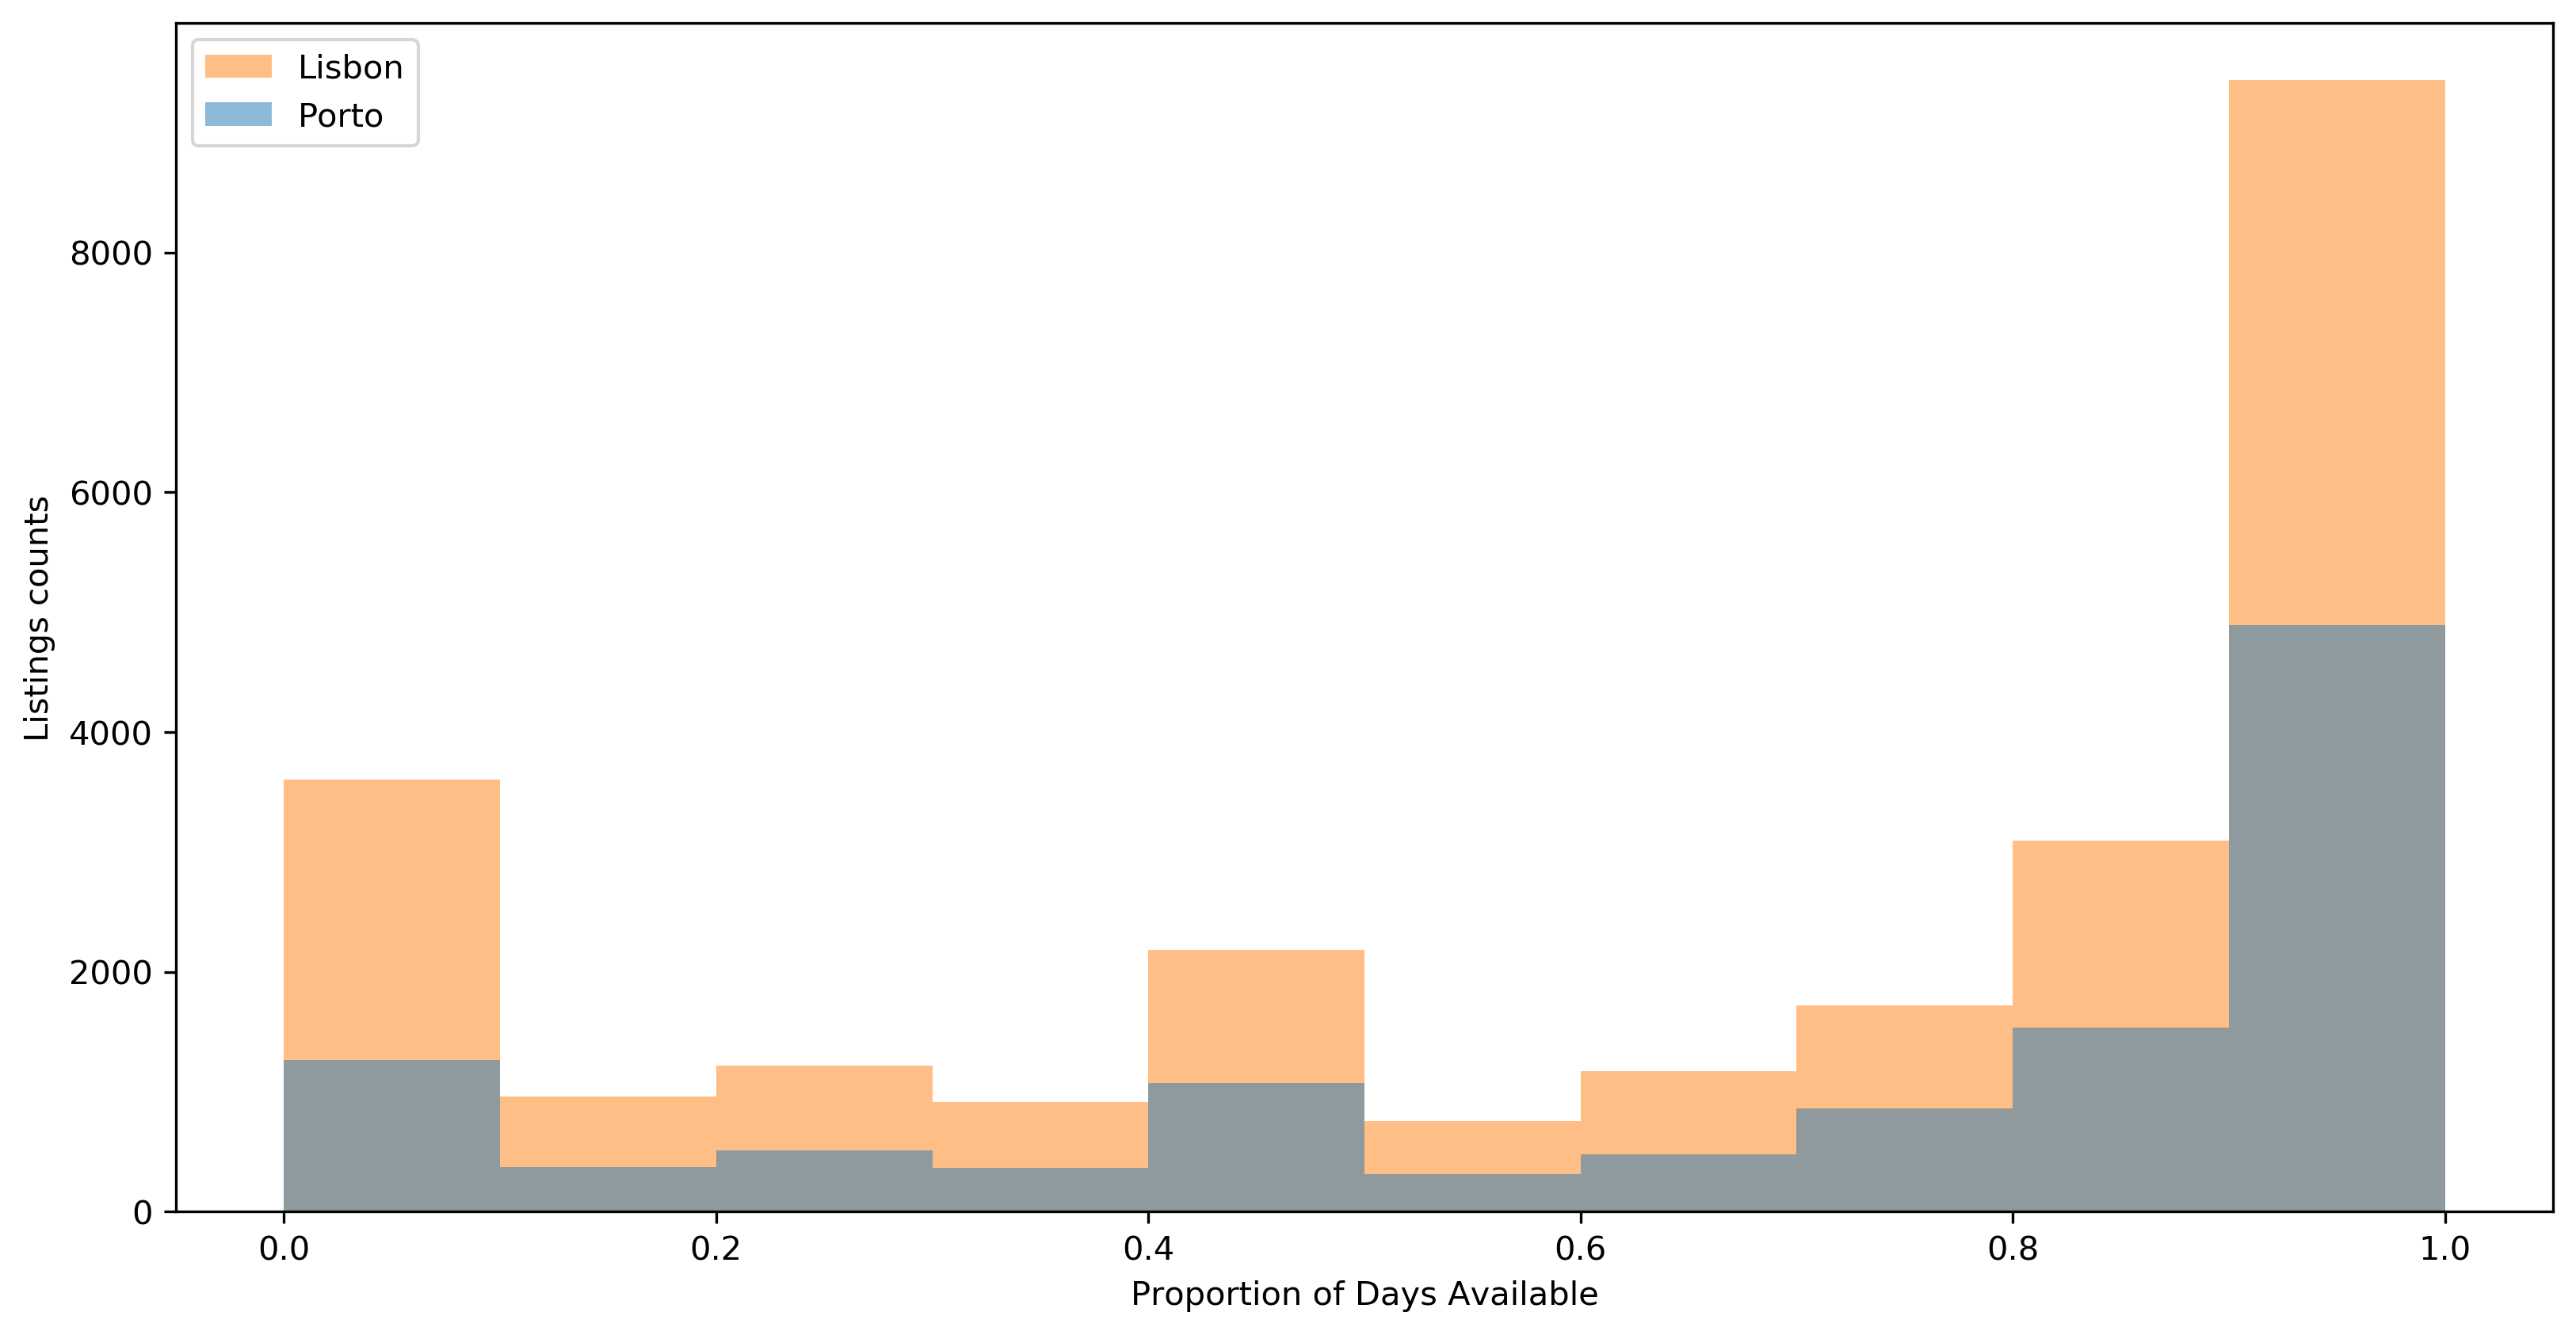

In [49]:
fig = plt.figure(figsize=(10,5),dpi=300)

ax = fig.add_axes([0,0,1,1])
ax.hist(lisbon_calendar_c.groupby('listing_id').mean()['available'],bins=10,alpha=0.5, label='Lisbon', color='#ff7f0e')
ax.hist(porto_calendar_c.groupby('listing_id').mean()['available'],bins=10,alpha=0.5, label='Porto')
ax.legend()
ax.set_xlabel('Proportion of Days Available')
ax.set_ylabel('Listings counts')


In [60]:
print('______________' + 'Porto availability at any given time' + '______________')
print('______________________', str(porto_calendar_c['available'].mean()*100), '_______________________')
print('______________' + 'Lisbon availability at any given time' + '_____________')
print('______________________', str(lisbon_calendar_c['available'].mean()*100), '______________________')

______________Porto availability at any given time______________
______________________ 68.42576226248343 _______________________
______________Lisbon availability at any given time_____________
______________________ 63.951138490876325 ______________________


It looks like there is a group of 'undesirables' that spend most of their time on airbnb completely available. curious if in the end we will discover why.
Other than that these are good news for travelers, you have a high chance to always find a place to stay.

listing_id                 int64
date              datetime64[ns]
available                  int64
price                    float64
adjusted_price           float64
minimum_nights             int64
maximum_nights             int64
dtype: object